In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [91]:
SIZE = 256
batch_size = 8
base_dir = '' # Local
num_workers = 1
lr = 0.0001
min_lr = 0.00001
epochs = 50
early_stopping = 5
# base_dir = '/content/' # Colab
root_path = os.path.join(base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
semantic = False
device = torch.device('cuda:0')

classes = ['normal', 'benign', 'malignant']
labels = []
num_classes = 3 if semantic else 1

if semantic:
    labels = classes
else:
    labels = ['cancer']

In [92]:
all_images = glob.glob(os.path.join(root_path, "**/*).png"), recursive=True)

image_paths = []
mask_paths = []

for path in all_images:
    if 'normal' in path:
        continue

    image_paths.append(path)
    cur_mask_path = []
    mask_path_1 = path.replace('.png', '_mask.png')
    mask_path_2 = path.replace('.png', '_mask_1.png')
    cur_mask_path.append(mask_path_1)
    if os.path.exists(mask_path_2):
        cur_mask_path.append(mask_path_2)
    mask_paths.append(cur_mask_path)

image_paths = np.array(image_paths)
mask_paths = np.array(mask_paths, dtype=object)

In [96]:
from data import *
from metrics import *
from utils import *
from models import *

dataset = BUSIDataset(image_paths=image_paths, mask_paths=mask_paths)

In [ ]:
unet_model = UNet(n_channels=1, n_classes=len(labels))
unet_model.load_state_dict(torch.load('models/UNet/model.pth'))
unet_model.to(device='cuda')
unet_model.eval()

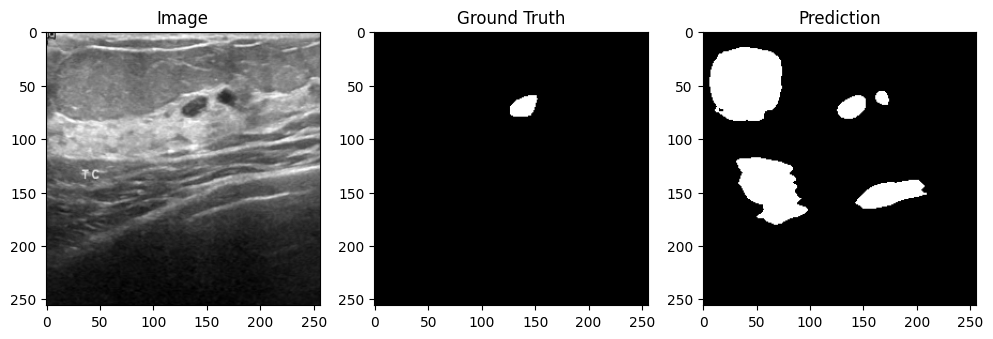

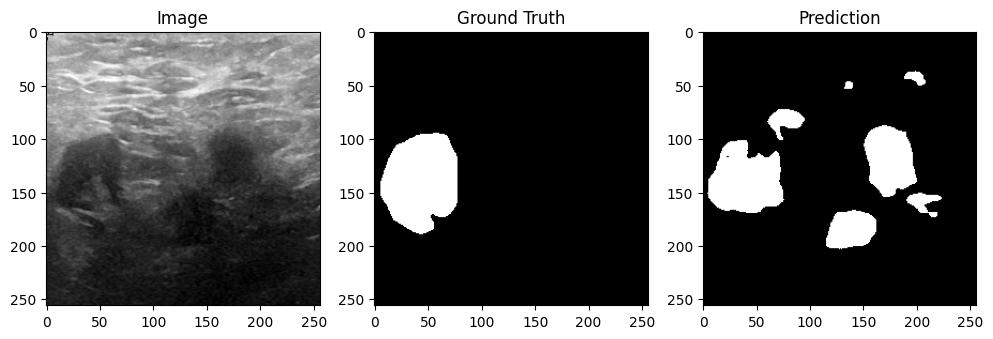

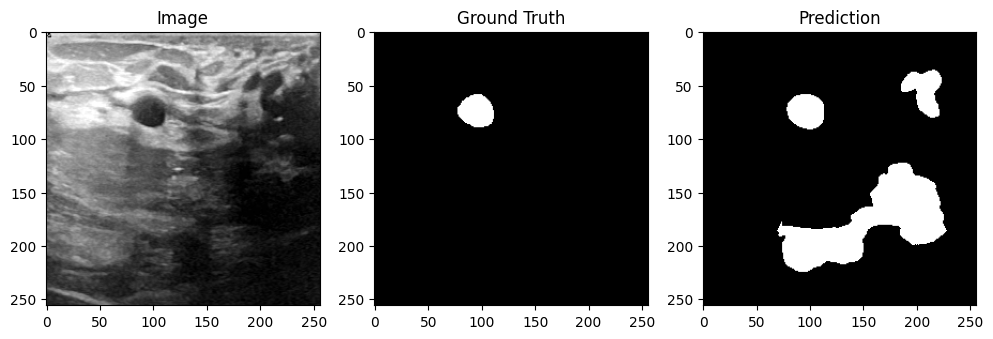

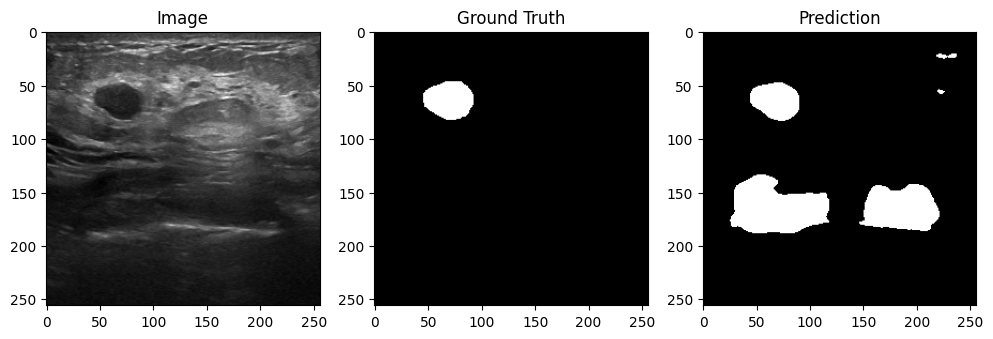

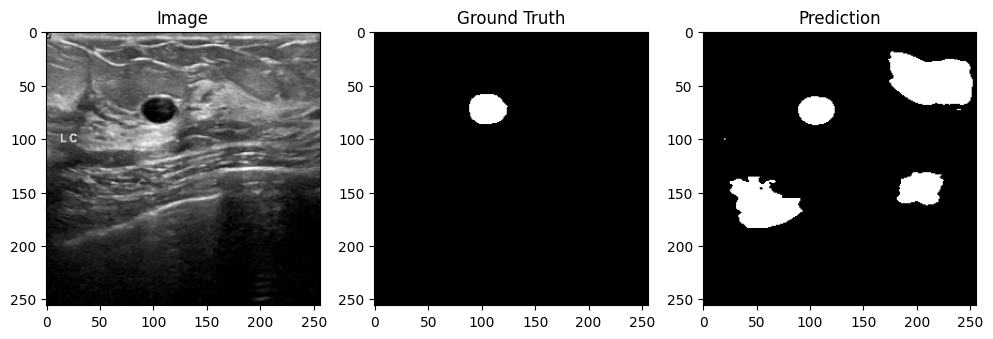

In [97]:
import models

def compare_models(model1_name, model2_name, count):
    model1 = models.__dict__[model1_name](n_channels=1, n_classes=1).cuda()
    model2 = models.__dict__[model2_name](n_channels=1, n_classes=1).cuda()

    model1.load_state_dict(torch.load(f'models/{model1_name}/model.pth'))
    model2.load_state_dict(torch.load(f'models/{model2_name}/model.pth'))

    for _ in range(count):

        idx = random.randint(0, len(image_paths) - 1)

        image, mask = load_tensor(image_paths[idx], mask_paths[idx])
        mask = mask.unsqueeze(0)
        image = image.unsqueeze(0)
        model1_prediction = model1(image)
        model2_prediction = model2(image)
        compare_prediction(image, mask, model1_prediction, model2_prediction)

compare_models('UNet', 'MR_UNet_HH', 5)

In [69]:
# print(sum(p.numel() for p in unet_model.parameters() if p.requires_grad))
# print(sum(p.numel() for p in mrunet_model.parameters() if p.requires_grad))
# print(sum(p.numel() for p in mrunet2_model.parameters() if p.requires_grad))

wunet = Wavelet_UNet(n_channels=1, n_classes=1)
print(sum(p.numel() for p in wunet.parameters() if p.requires_grad))

17261825


In [2]:
import pandas as pd

def print_status(model_name):
    path = f"models/{model_name}/log.csv"
    log = pd.read_csv(path)
    best_score = log['val_dice'].max()
    # print total row count of the log    
    print(f"{model_name} - Best Val Dice Score: {best_score}, Total Epochs: {len(log)}")

In [22]:
print_status('UNet')
print_status('MR_UNet')
print_status('MR_UNet2')
print_status('MR_UNet_HH')
print_status('MR_UNet_All')
print_status('Wavelet_UNet')
print_status('Wavelet_UNet_All')

UNet - Best Val Dice Score: 0.811262865456315, Total Epochs: 88
MR_UNet - Best Val Dice Score: 0.7980237296430797, Total Epochs: 100
MR_UNet2 - Best Val Dice Score: 0.8107432608493343, Total Epochs: 100
MR_UNet_HH - Best Val Dice Score: 0.7170866366114018, Total Epochs: 61
MR_UNet_All - Best Val Dice Score: 0.8095692252149866, Total Epochs: 100
Wavelet_UNet - Best Val Dice Score: 0.8030659837985603, Total Epochs: 246
Wavelet_UNet_All - Best Val Dice Score: 0.8087399622054466, Total Epochs: 91


(1, 3, 256, 256)


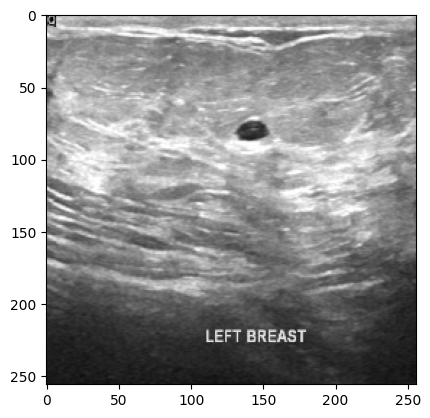

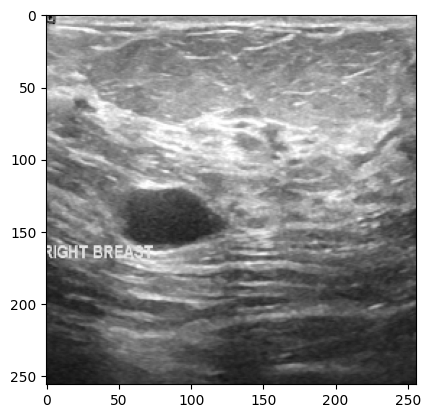

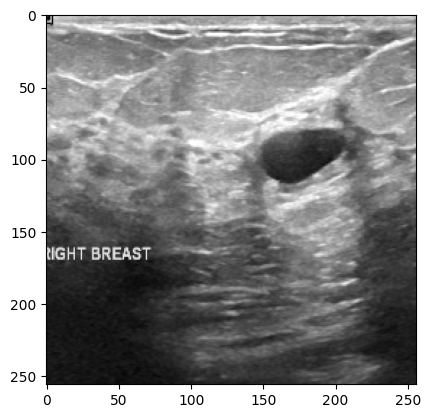

torch.Size([1, 12, 128, 128])


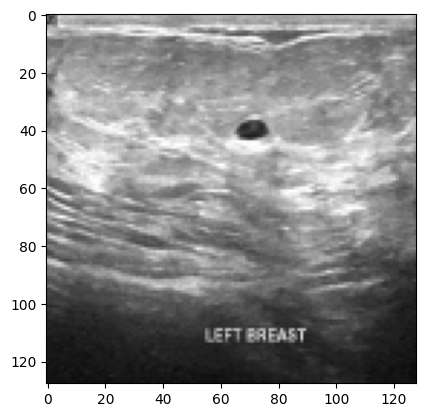

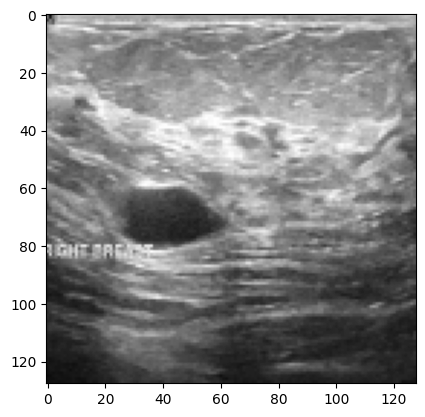

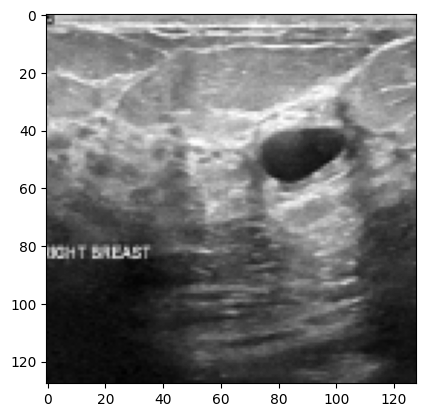

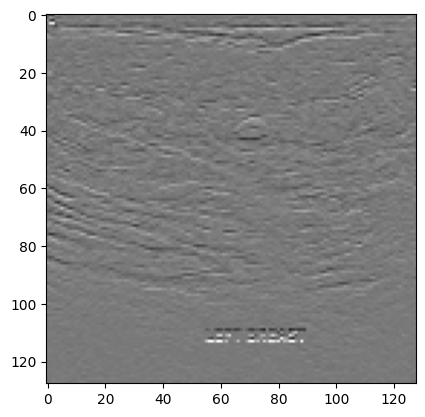

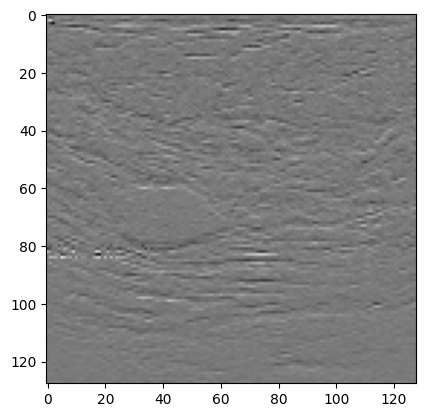

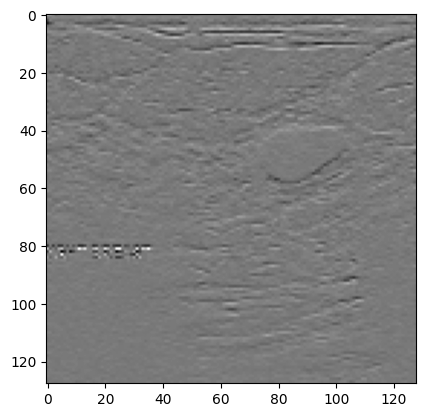

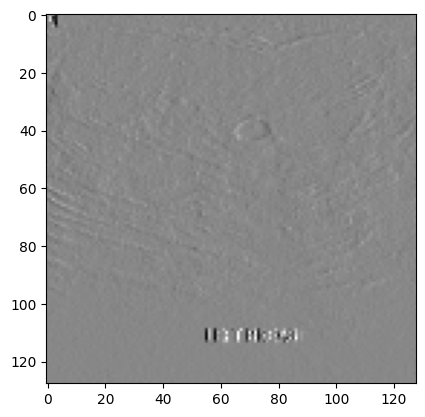

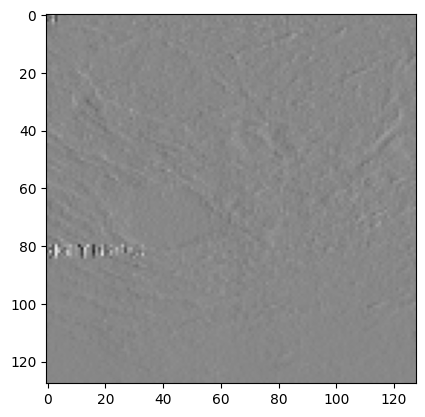

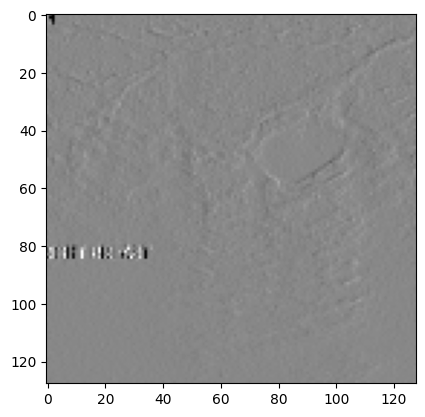

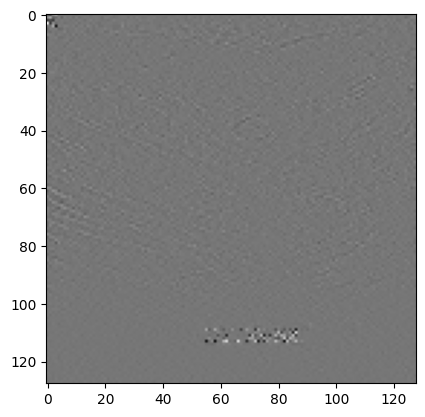

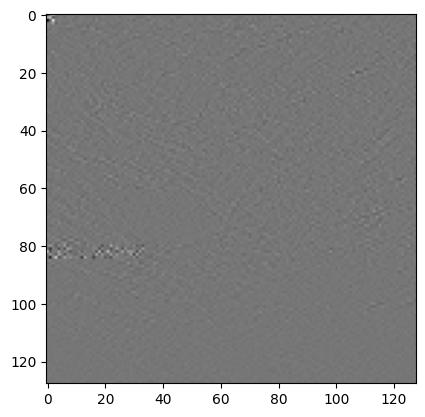

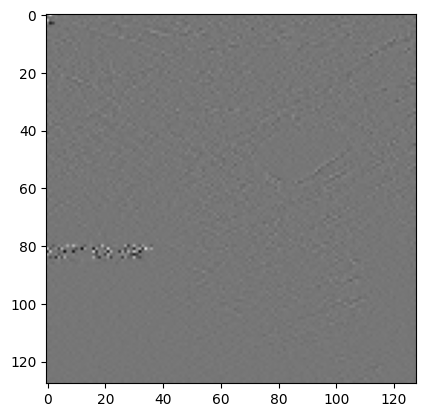

In [2]:
from transform2d import DWTForward, DWTInverse
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import numpy as np

class WaveletDownsamplingAll(nn.Module):
    def __init__(self, wavelet='db1', level=1):
        super(WaveletDownsamplingAll, self).__init__()
        self.wavelet = wavelet
        self.level = level
        self.dwt_forward = DWTForward(wave=self.wavelet, J=self.level)

    def forward(self, x):
        coeffs = self.dwt_forward(x)
        # extract all 4 channels, ll, hl, lh, hh
        ll = coeffs[0]
        lh = coeffs[1][0][:, :, 0]
        hl = coeffs[1][0][:, :, 1]
        hh = coeffs[1][0][:, :, 2]
        # normalize all 4 channels
        ll = (ll - ll.min()) / (ll.max() - ll.min())
        lh = (lh - lh.min()) / (lh.max() - lh.min())
        hl = (hl - hl.min()) / (hl.max() - hl.min())
        hh = (hh - hh.min()) / (hh.max() - hh.min())
        # concatenate the 4 channels
        f = torch.cat([ll, lh, hl, hh], dim=1)
        return f

image1 = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
image1 = cv2.imread(image1)
image1 = cv2.resize(image1, (256, 256))
image1 = image1[:, :, 0]
image1 = np.expand_dims(image1, 0)

image2 = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png'
image2 = cv2.imread(image2)
image2 = cv2.resize(image2, (256, 256))
image2 = image2[:, :, 0]
image2 = np.expand_dims(image2, 0)

image3 = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (3).png'
image3 = cv2.imread(image3)
image3 = cv2.resize(image3, (256, 256))
image3 = image3[:, :, 0]
image3 = np.expand_dims(image3, 0)

image = np.concatenate([image1, image2, image3], axis=0)
image = np.expand_dims(image, 0)

print(image.shape)

image = torch.tensor(image).to(device='cuda', dtype=torch.float)
downsampled_image = WaveletDownsamplingAll().cuda()(image)

image = image/255.0

plt.imshow(image[0,0].cpu().numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(image[0,1].cpu().numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(image[0,2].cpu().numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()



print(downsampled_image.shape)
for i in range(12):
    plt.imshow(downsampled_image[0,i].cpu().numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.show()